In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Pull and assess the data set. 
diabteus = pd.read_csv('diabetes.csv')
diabteus.info(verbose=True)
diabteus.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


## Rationalizing the Features and Understanding the Values

Each row represents a patient that is assessed using 9 features.
All 9 features have no missing (NaN) values. At a first glance it looks good but there's 0 value as the min for the first 6 features: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI]. 

We should first understand each feature to see if the 0 values make sense. 

**Prengnancies**: This is a discrete number referring to the amount of pregnancies a patient had. This checks out. 

**Glucose**: Typical blood glucose range for adults is between 70 - 140 mg/dL. Hypoglycemia (low blood sugar) isn't a natural condition for patients regardless of the circumstance. Hence 0 values don't make sense.

**BloodPressure**: Typically, Hypotension (Low BP) values are below 90/60 mmHg but never 0 because that implies a lack of blood pressure.

**SkinThickness**: This is measured via calipers on the tricep. If a patient doesn't have skinthickness then they are ghosts. 0 doesn't make sense.

**Insulin**: This is a 2 hour postprandial (after eating) measurement of insulin in patients. This means that with the advent of glucose via food, insulin levels should have spiked and returned to baseline within this time. If Baseline = 0, we have problems. 

**BMI**: BMI = Weight (kg)/ Height (m^2). Unless weight = 0, we cannot arrive at 0. 

So [Glucose, BloodPressure, SkinThickness, Insulin, BMI] requires cleaning. Easier to delete these entries but we only have 768 entries so we want to preserve as much as possible. Thus we must impute these values (fill with placeholder values) with those that have minimal impact on the distribution of each feature so as to preserve the pattern. 

Or We can also use XGBoost which has built in NaN handling.

But let's also understand Diabetes Pedigree, Age and Outcome. 

**DiabetesPedigreeFunction** is a score that estimates the likelihood of diabetes based on an individual's family history of diabetes and age. It's a crucial factor in predicting diabetes risk, with higher DPF scores indicating a greater probability of having the disease. 

**Age** is just a number ;).

**Outcome** is either 1 = Diabetic or 0 = Non Diabetic. 

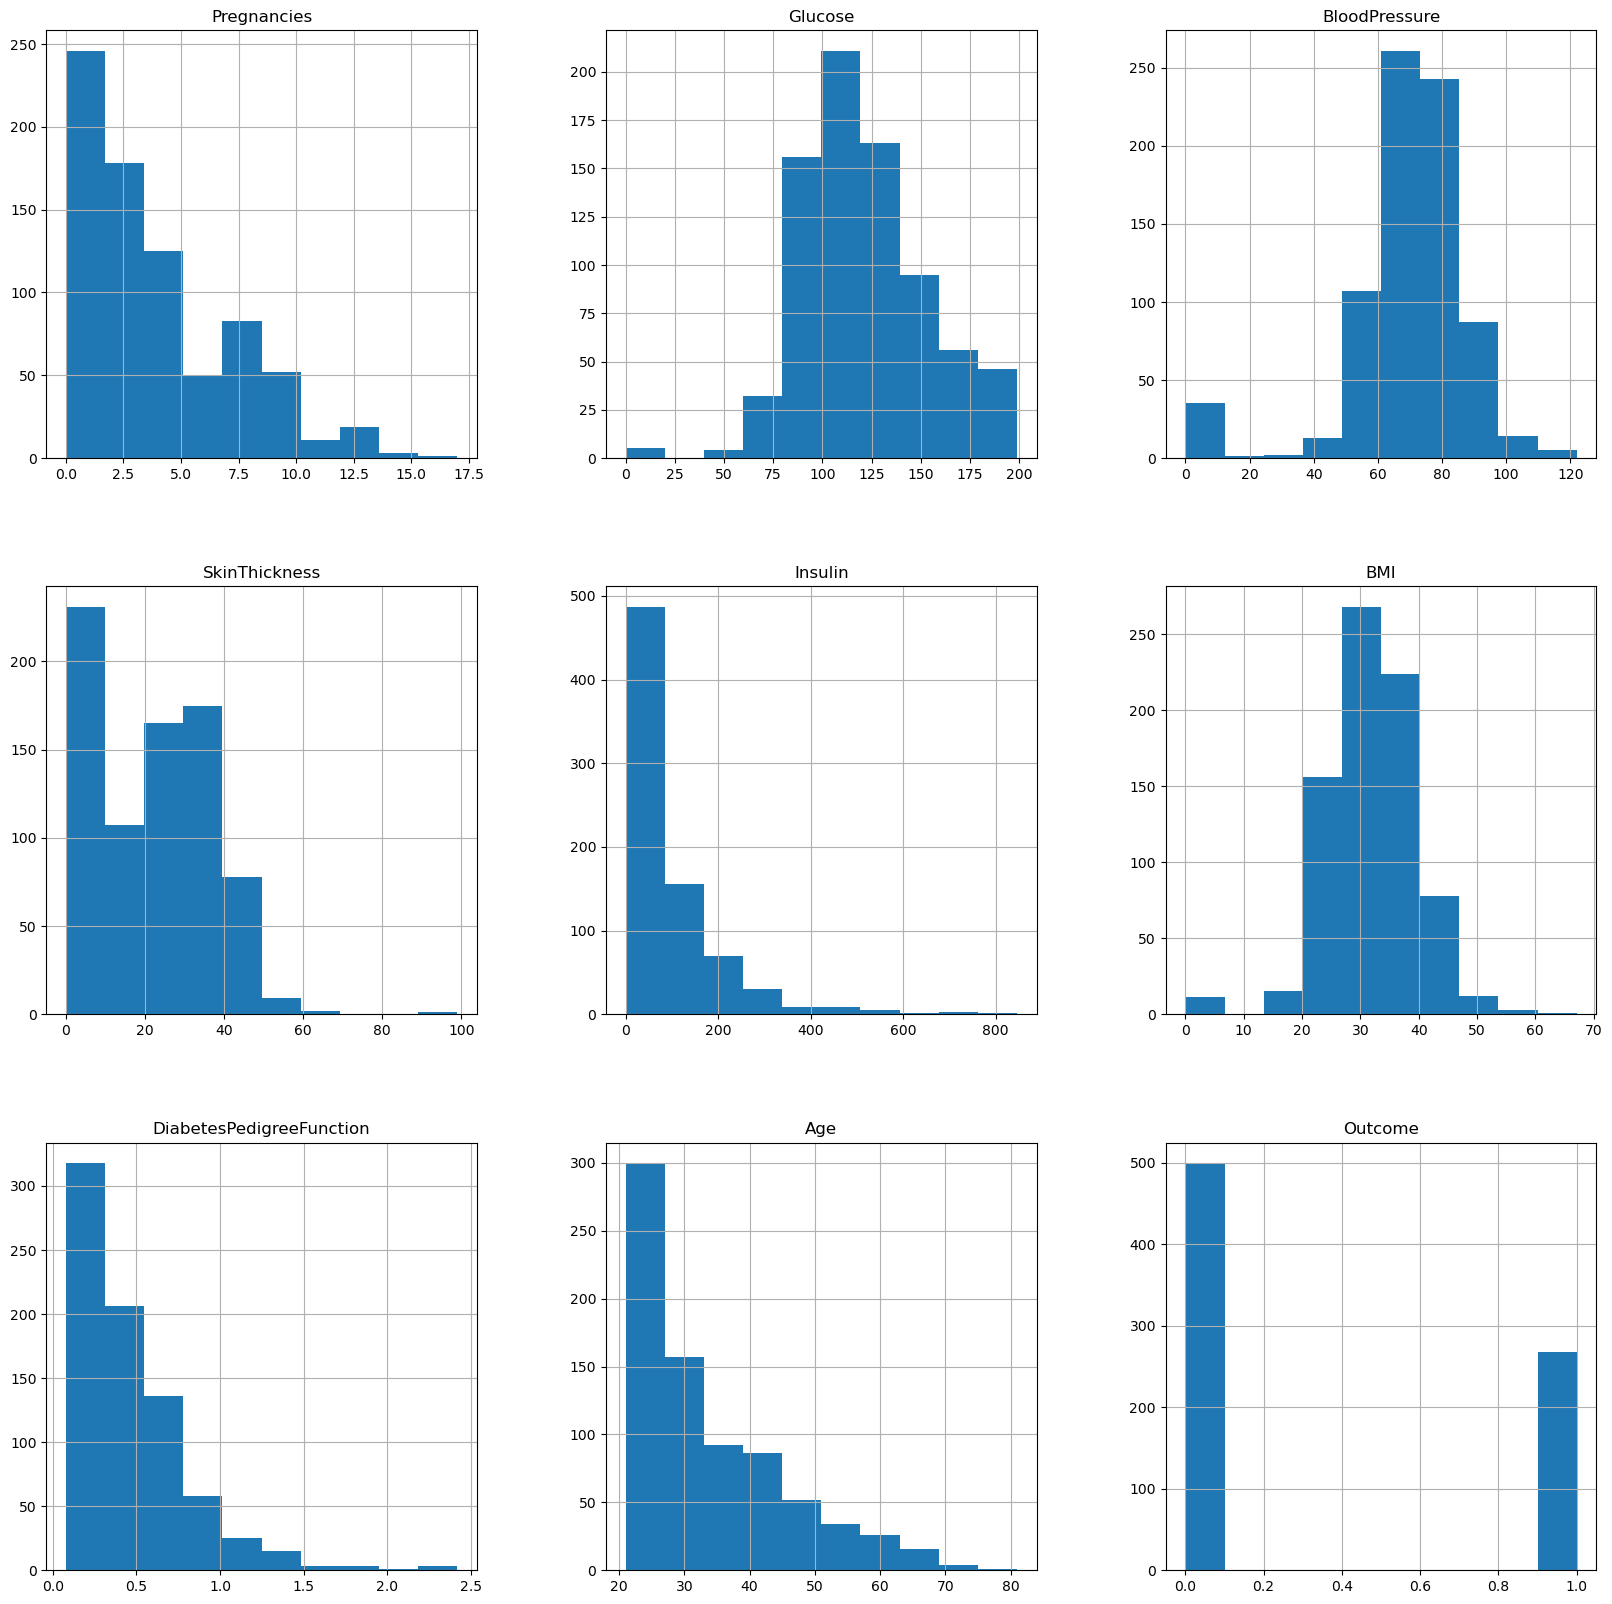

In [11]:
# Distribution of each feature
p = diabteus.hist(figsize=(20,20))

There's Skewness for Insulin and Skinthickness. To better resist outliers, we should imput with Median instead. Mean also works for Glucose and BP but use Median for consistency. 

In [ ]:
# Grab column names
columns = diabteus.columns.tolist()
missing_cols = columns[1:6]

# QC
print(columns, missing_cols)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'] ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


In [18]:
# Replace Missing 0's with NaN and show
diabteus_nan = diabteus.copy(deep=True)
diabteus_nan[missing_cols] = diabteus_nan[missing_cols].replace(0, np.nan)
print("Missing values per column:\n", diabteus_nan.isnull().sum())

Missing values per column:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Cross Roads: XGBoost vs Logistic Regression. 

### XGBoost
XGBoost uses a tree based model and thus does not require scaling and is built to handle NaN values. When encountering NaN values, XGBoost automatically routes the data to either left or right of the branch based on which ever branch has the lowest loss. Additionally, XG Boost does not require the dataset to be scaled. Which means we can start working with the dataset as it is [(source)](https://jimmy-wang-gen-ai.medium.com/how-do-xgboost-lightgbm-and-catboost-handle-missing-features-e541da94d528).

### Logistic Regression